## Retinal vessel detection

In [29]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import frangi
from skimage.morphology import remove_small_objects
from skimage.util import img_as_bool
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from skimage.measure import moments_central, moments_hu
from sklearn.utils import resample
import joblib
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [13]:
def load_image(file_name):
    base_name = os.path.splitext(file_name)[0]

    img_path = os.path.join("./HRF/healthy", base_name + ".jpg")
    img = cv2.imread(img_path)

    manual_path = os.path.join("./HRF/healthy_manualsegm", base_name + ".tif")
    manual = cv2.imread(manual_path, 0)
    
    fov_path = os.path.join("./HRF/healthy_fovmask", base_name + "_mask.tif")
    fov = cv2.imread(fov_path, 0)

    return img, manual // 255, fov // 255

### 1. Image processing

In [14]:
def preprocessing(image):
    green_image = image[:,:,1]
    denoised_image = cv2.medianBlur(green_image, 5)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    eqaualized_image = clahe.apply(denoised_image)

    return eqaualized_image

In [15]:
def image_processing(image, fov_mask):
    preprocessed_image = preprocessing(image)

    frangi_image = frangi(preprocessed_image)
    
    fov_bin = (fov_mask > 0).astype(np.uint8)
    frangi_image = frangi_image * fov_bin

    normalized_frangi_image = cv2.normalize(frangi_image, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    binary_vessels = normalized_frangi_image.copy()
    binary_vessels[binary_vessels > 0] = 255  # binary mask

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    opened_img = cv2.morphologyEx(binary_vessels, cv2.MORPH_OPEN, kernel, iterations=2)
    
    dilated_img = cv2.dilate(opened_img, kernel, iterations=3)

    bool_dilated = img_as_bool(dilated_img)
    cleaned_dilated = remove_small_objects(bool_dilated, min_size=1000)
    final_img = (cleaned_dilated * 255).astype(np.uint8)

    return final_img


In [16]:
def show_results(image, vessels_mask, manual):
    bgr_image = image.copy()
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)
    rgb_image[vessels_mask > 0] = [0, 0, 255]
    
    plt.figure(figsize=(18, 6))

    plt.subplot(1, 3, 1)
    plt.title("Ground truth (manual mask)")
    plt.imshow(manual, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title("Detected vessels")
    plt.imshow(vessels_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title("Visualization of vessel detection")
    plt.imshow(rgb_image, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [17]:
def evaluate_detection(manual_mask, detected_mask, fov):
    mask = fov > 0
    y_true = manual_mask[mask].flatten()
    y_pred = (detected_mask[mask] > 0).astype(np.uint8).flatten()

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    arithmetic_mean = (sensitivity + specificity) / 2
    geometric_mean = np.sqrt(sensitivity * specificity)

    print(f"accuracy: {accuracy:.4f}, sensitivity: {sensitivity:.4f}, specificity: {specificity:.4f}, arithmetic mean: {arithmetic_mean:.4f}, geometric mean: {geometric_mean:.4f}")

    plt.figure(figsize=(3, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

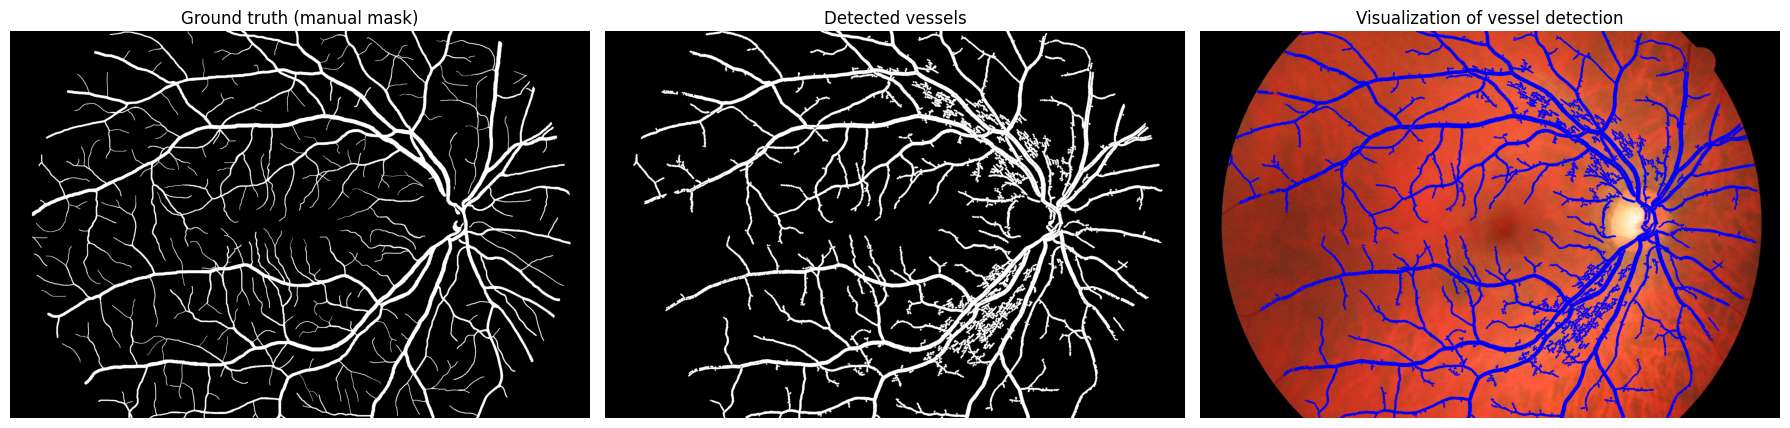

accuracy: 0.9202, sensitivity: 0.8124, specificity: 0.9350, arithmetic mean: 0.8737, geometric mean: 0.8715


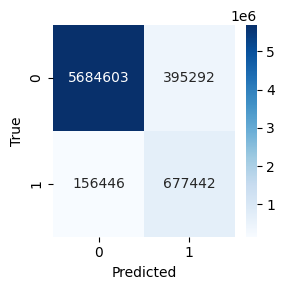

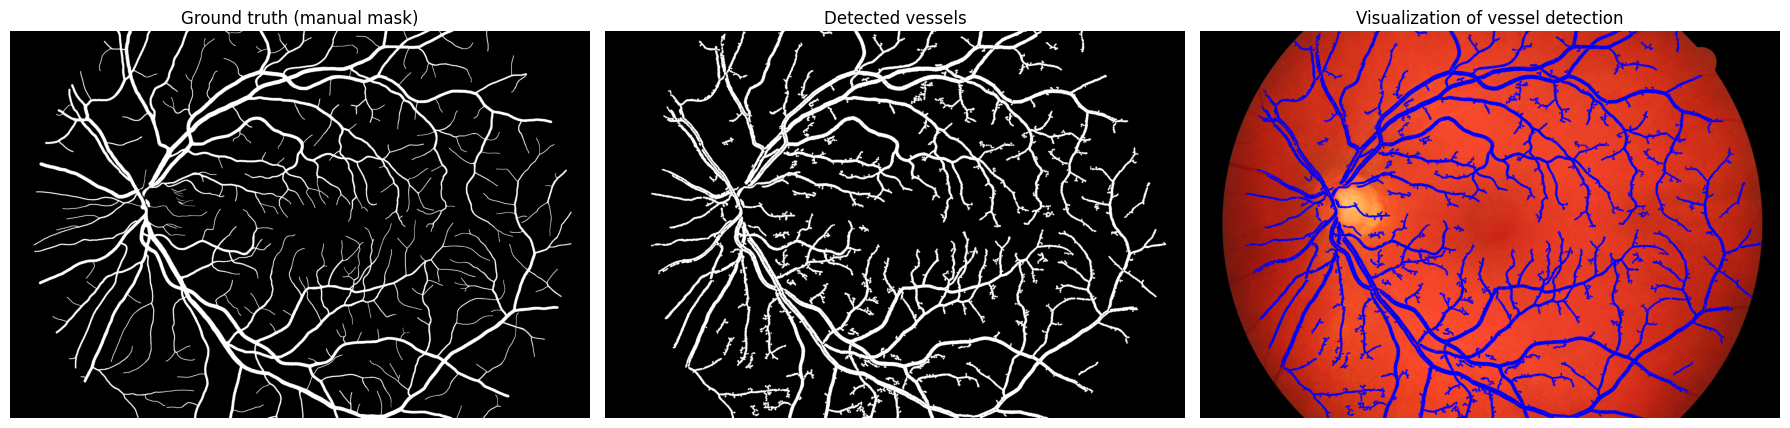

accuracy: 0.9290, sensitivity: 0.8512, specificity: 0.9395, arithmetic mean: 0.8954, geometric mean: 0.8943


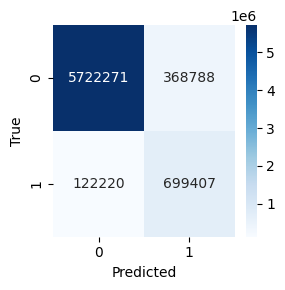

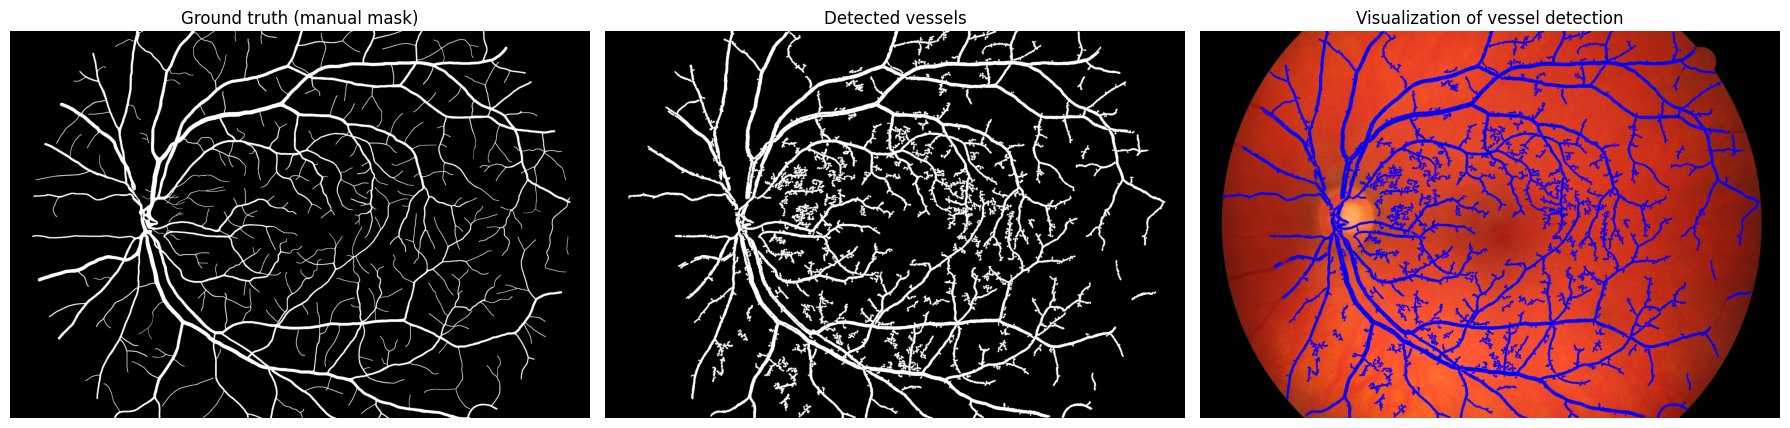

accuracy: 0.9140, sensitivity: 0.8332, specificity: 0.9232, arithmetic mean: 0.8782, geometric mean: 0.8771


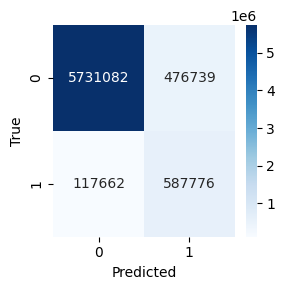

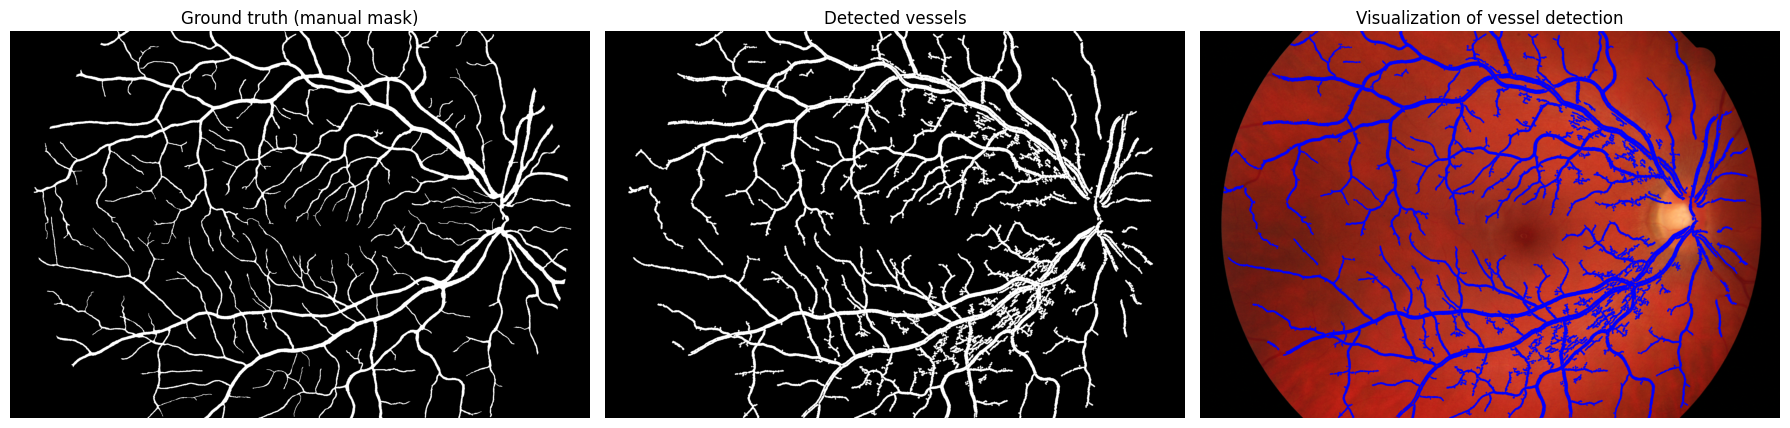

accuracy: 0.9235, sensitivity: 0.8341, specificity: 0.9346, arithmetic mean: 0.8843, geometric mean: 0.8829


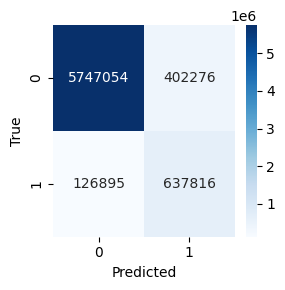

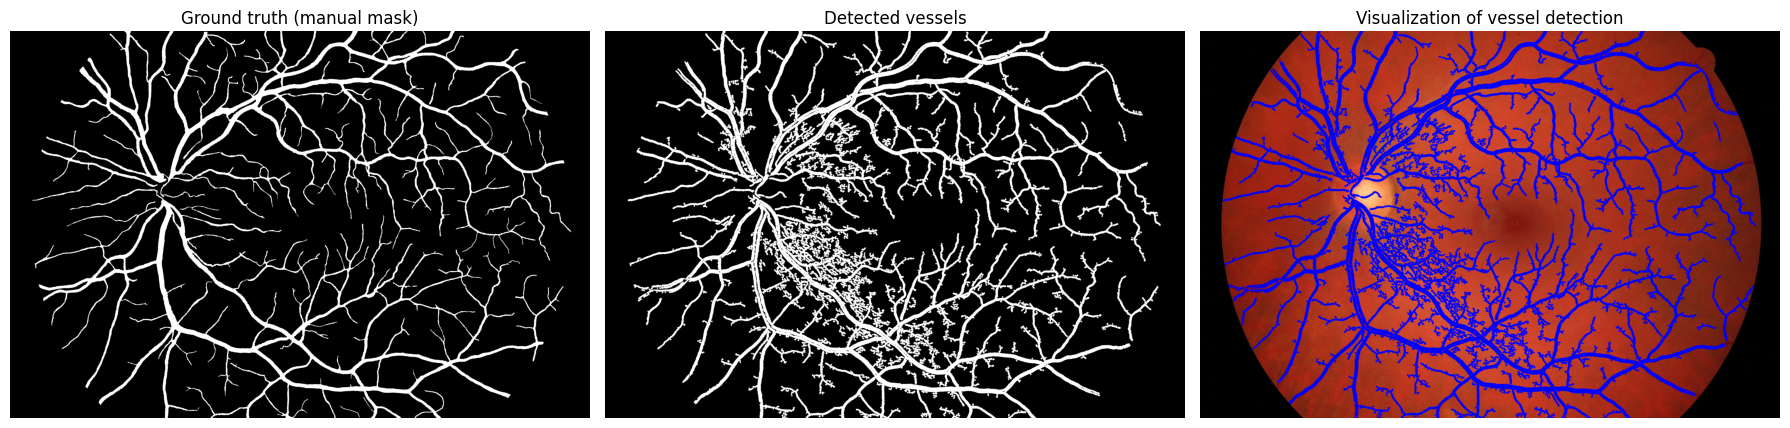

accuracy: 0.8995, sensitivity: 0.9081, specificity: 0.8983, arithmetic mean: 0.9032, geometric mean: 0.9032


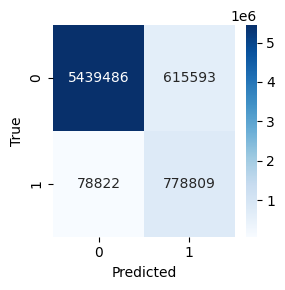

In [18]:
test_data = ["01_h.jpg", "08_h.jpg", "10_h.jpg", "11_h.jpg", "12_h.jpg"]

for i in test_data:
    img, manual, fov = load_image(i)
    vessels = image_processing(img, fov)
    show_results(img, vessels, manual)
    evaluate_detection(manual, vessels, fov)

### 2. Machine learning classifier

In [19]:
def extract_features(image, manual_mask, fov, patch_size=5):
    features = []
    labels = []
    offset = patch_size // 2
    green = preprocessing(image)

    for y in range(offset, green.shape[0] - offset):
        for x in range(offset, green.shape[1] - offset):
            if fov[y, x] == 0:
                continue

            patch = green[y-offset:y+offset+1, x-offset:x+offset+1]
            if patch.shape != (patch_size, patch_size):
                continue

            var = np.var(patch)
            m = moments_central(patch)
            hu = moments_hu(m)
            label = manual_mask[y, x]  # środek patcha

            feat = [var] + list(hu)
            features.append(feat)
            labels.append(label)

    return np.array(features), np.array(labels)

In [20]:
def train_or_load_model(model_path, training_files):
    if os.path.exists(model_path):
        clf = joblib.load(model_path)
        print("Model loaded.")
    else:
        print("Model not found, training model...")
        all_features = []
        all_labels = []

        for file in training_files:
            img, manual, fov = load_image(file)
            features, labels = extract_features(img, manual, fov)
            all_features.append(features)
            all_labels.append(labels)

        X = np.vstack(all_features)
        y = np.hstack(all_labels)

        pos = X[y == 1]
        neg = X[y == 0]
        neg_downsampled = resample(neg, replace=False, n_samples=len(pos), random_state=42)

        X_balanced = np.vstack((pos, neg_downsampled))
        y_balanced = np.array([1]*len(pos) + [0]*len(neg_downsampled))

        X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

        clf = RandomForestClassifier(n_estimators=100, random_state=42)
        clf.fit(X_train, y_train)

        joblib.dump(clf, model_path)
        print("Model saved.")

    return clf

In [21]:
def predict_image(image, fov, clf, patch_size=5, batch_size=10000):
    green = preprocessing(image)
    offset = patch_size // 2
    h, w = green.shape

    features = []
    coords = []
    
    for y in range(offset, h - offset):
        for x in range(offset, w - offset):
            if fov[y, x] == 0:
                continue

            patch = green[y - offset:y + offset + 1, x - offset:x + offset + 1]
            if patch.shape != (patch_size, patch_size):
                continue

            var = np.var(patch)
            m = moments_central(patch)
            hu = moments_hu(m)
            feat = [var] + list(hu)

            features.append(feat)
            coords.append((y, x))

    pred_mask = np.zeros((h, w), dtype=np.uint8)
    for i in tqdm(range(0, len(features), batch_size), desc="Progress:"):
        batch_feats = features[i:i + batch_size]
        batch_coords = coords[i:i + batch_size]
        preds = clf.predict(batch_feats)

        for (y, x), pred in zip(batch_coords, preds):
            if pred == 1:
                pred_mask[y, x] = 255

    return pred_mask

In [ ]:
test_files = ["01_h.jpg", "08_h.jpg", "10_h.jpg", "11_h.jpg", "12_h.jpg"]
train_files = ["02_h.jpg", "03_h.jpg", "04_h.jpg", "05_h.jpg", "06_h.jpg"]

model_path = "classifier.pkl"
clf = train_or_load_model(model_path, train_files)

for file in test_files:
    print(f"\n{file}")
    img, manual, fov = load_image(file)
    predicted = predict_image(img, fov, clf)
    show_results(img, predicted, manual)
    evaluate_detection(manual, predicted, fov)


Model not found, training model...


NameError: name 'preprocessing' is not defined

### 3. Deep learning model

In [30]:
def prepare_unet_data(images, masks, fovs, patch_size=128):
    patches = []
    mask_patches = []
    
    for img, mask, fov in zip(images, masks, fovs):
        # Preprocessing
        processed_img = preprocessing(img)
        
        # Apply FOV mask
        processed_img = processed_img * fov
        mask = mask * fov
        
        h, w = processed_img.shape
        
        # Podziel obraz na łatki (patches)
        for i in range(0, h - patch_size, patch_size):
            for j in range(0, w - patch_size, patch_size):
                # Sprawdź, czy w łatce jest jakakolwiek część FOV
                fov_patch = fov[i:i+patch_size, j:j+patch_size]
                if np.sum(fov_patch) == 0:
                    continue
                
                patch = processed_img[i:i+patch_size, j:j+patch_size]
                mask_patch = mask[i:i+patch_size, j:j+patch_size]
                
                # Normalizacja
                patch = (patch - np.min(patch)) / (np.max(patch) - np.min(patch)) if np.max(patch) > np.min(patch) else patch

            

                patches.append(patch)
                mask_patches.append(mask_patch)
    
    return np.array(patches), np.array(mask_patches)


In [31]:
def build_unet(input_shape=(128, 128, 1)):
    inputs = layers.Input(input_shape)
    
    # Encoder
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)
    
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)
    
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)
    
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = layers.Dropout(0.2)(c4)
    c4 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    # Bridge
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = layers.Dropout(0.3)(c5)
    c5 = layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Decoder
    u6 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = layers.Dropout(0.2)(c6)
    c6 = layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = layers.Dropout(0.2)(c7)
    c7 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    
    u8 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = layers.Dropout(0.1)(c8)
    c8 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = layers.concatenate([u9, c1], axis=3)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = layers.Dropout(0.1)(c9)
    c9 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
    
    model = models.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer=Adam(learning_rate=1e-4), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    
    return model


In [32]:
# Funkcja do trenowania modelu U-Net
def train_or_load_unet(model_path, train_files, epochs=50, batch_size=16, validation_split=0.2):
    if os.path.exists(model_path):
        model = models.load_model(model_path)
        print("Model loaded from disk.")
    else:
        print("Training new model...")
        # Wczytanie danych treningowych
        images = []
        manuals = []
        fovs = []
        
        for file in train_files:
            img, manual, fov = load_image(file)
            images.append(img)
            manuals.append(manual)
            fovs.append(fov)
        
        # Przygotowanie danych
        X, y = prepare_unet_data(images, manuals, fovs)
        X = X[..., np.newaxis]  # Dodanie wymiaru kanału
        y = y[..., np.newaxis]
        
        # Podział na zbiór treningowy i walidacyjny
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
        
        # Budowa modelu
        model = build_unet(input_shape=X_train.shape[1:])
        
        # Callbacks
        callbacks = [
            EarlyStopping(patience=10, verbose=1),
            ModelCheckpoint(model_path, verbose=1, save_best_only=True)
        ]
        
        # Trenowanie modelu
        history = model.fit(
            X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=callbacks
        )
        
        # Wykresy treningu
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.legend()
        plt.title('Loss Evolution')
        
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.legend()
        plt.title('Accuracy Evolution')
        
        plt.tight_layout()
        plt.show()
    
    return model


In [33]:
def predict_with_unet(model, image, fov, patch_size=128):
    # Preprocessing
    processed_img = preprocessing(image)
    processed_img = processed_img * fov
    
    h, w = processed_img.shape
    
    # Dopasowanie rozmiaru obrazu do wielokrotności patch_size
    new_h = ((h // patch_size) + 1) * patch_size if h % patch_size != 0 else h
    new_w = ((w // patch_size) + 1) * patch_size if w % patch_size != 0 else w
    
    # Wypełnienie zerami jeśli potrzebne
    padded_image = np.zeros((new_h, new_w))
    padded_image[:h, :w] = processed_img
    
    # Podział na łatki
    patches = []
    coords = []
    for i in range(0, new_h, patch_size):
        for j in range(0, new_w, patch_size):
            # Sprawdź, czy w łatce jest jakakolwiek część FOV
            fov_patch = fov[i:i+patch_size, j:j+patch_size] if i < h and j < w else np.zeros((patch_size, patch_size))
            if np.sum(fov_patch) == 0:
                continue
                
            patch = padded_image[i:i+patch_size, j:j+patch_size]
            patches.append(patch)
            coords.append((i, j))
    
    # Predykcja
    patches = np.array(patches)[..., np.newaxis]
    preds = model.predict(patches, batch_size=8)
    
    # Składanie predykcji z powrotem w cały obraz
    reconstructed = np.zeros((new_h, new_w))
    for (i, j), pred in zip(coords, preds):
        reconstructed[i:i+patch_size, j:j+patch_size] = pred.squeeze()

    reconstructed = reconstructed[:h, :w]
    reconstructed = reconstructed * fov
    
    # Przycięcie do oryginalnych wymiarów
    return reconstructed


Model loaded from disk.

01_h.jpg
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 186ms/step


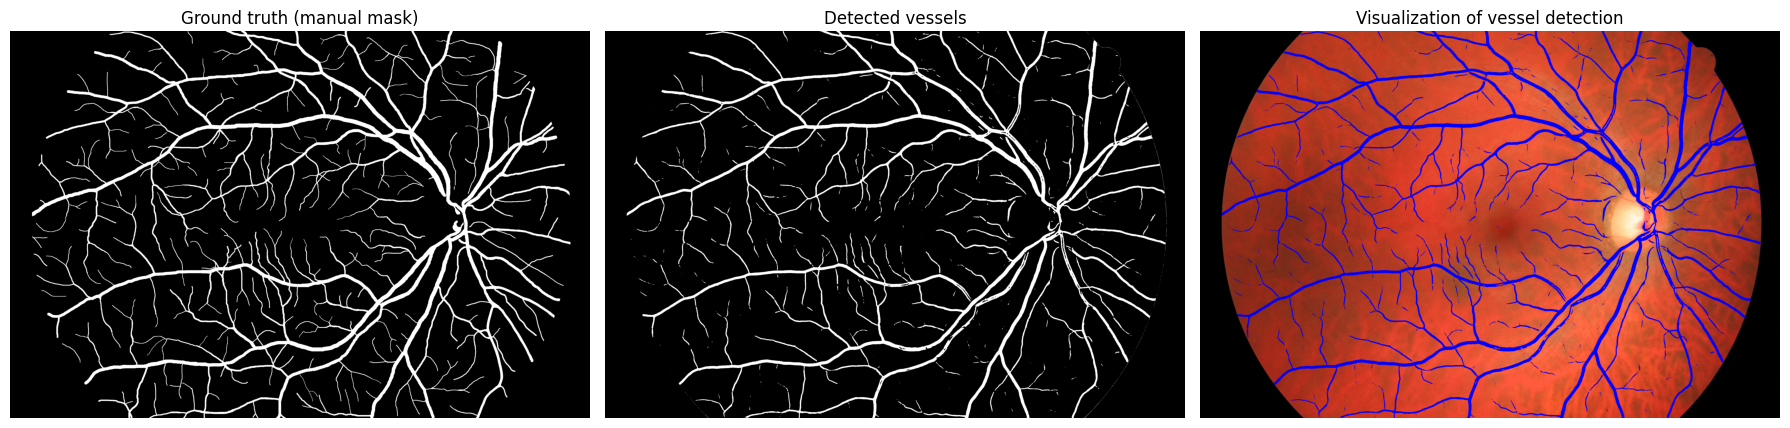

accuracy: 0.9540, sensitivity: 0.8463, specificity: 0.9687, arithmetic mean: 0.9075, geometric mean: 0.9055


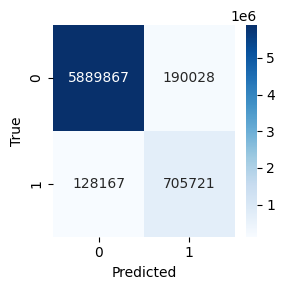


08_h.jpg
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 181ms/step


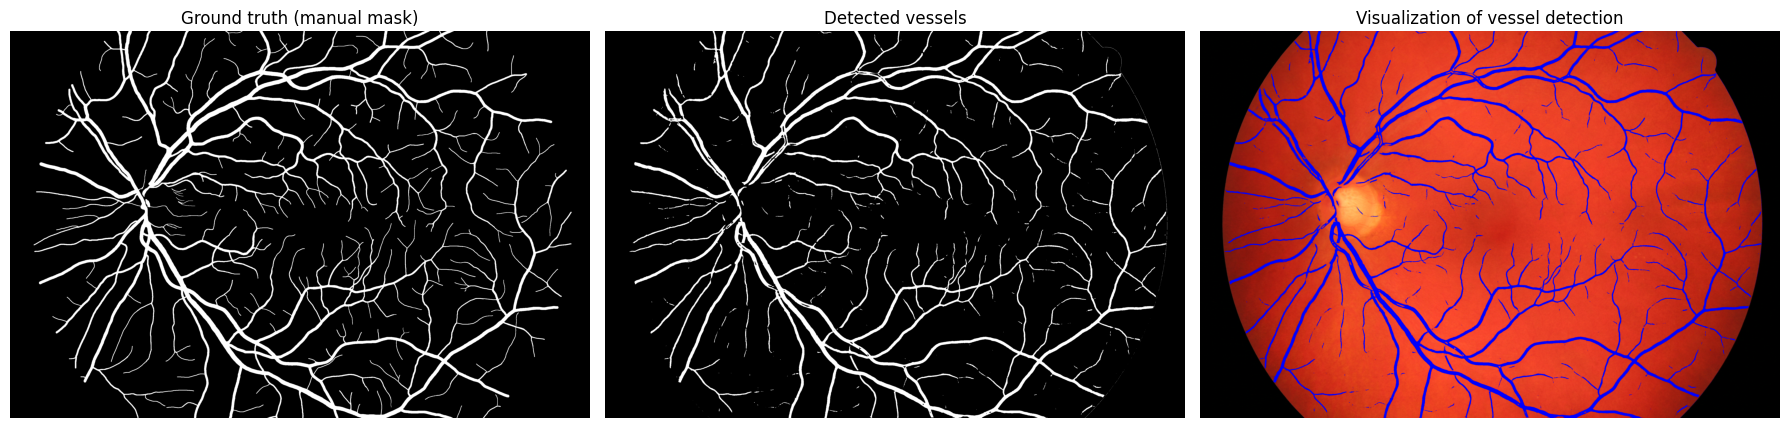

accuracy: 0.9538, sensitivity: 0.8947, specificity: 0.9618, arithmetic mean: 0.9282, geometric mean: 0.9276


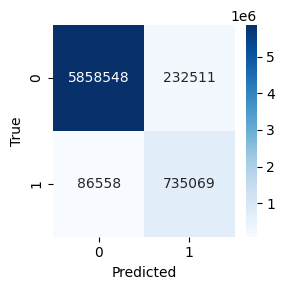


10_h.jpg
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 161ms/step


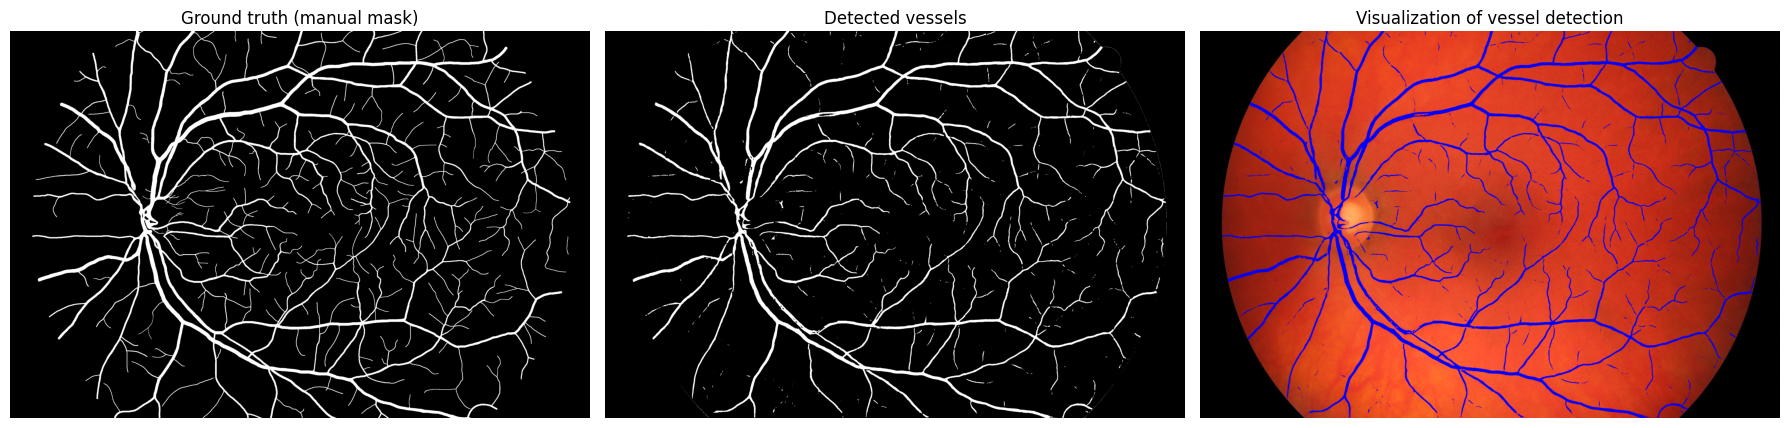

accuracy: 0.9521, sensitivity: 0.8641, specificity: 0.9621, arithmetic mean: 0.9131, geometric mean: 0.9118


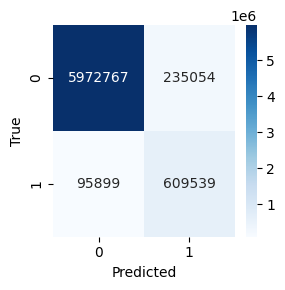


11_h.jpg
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step


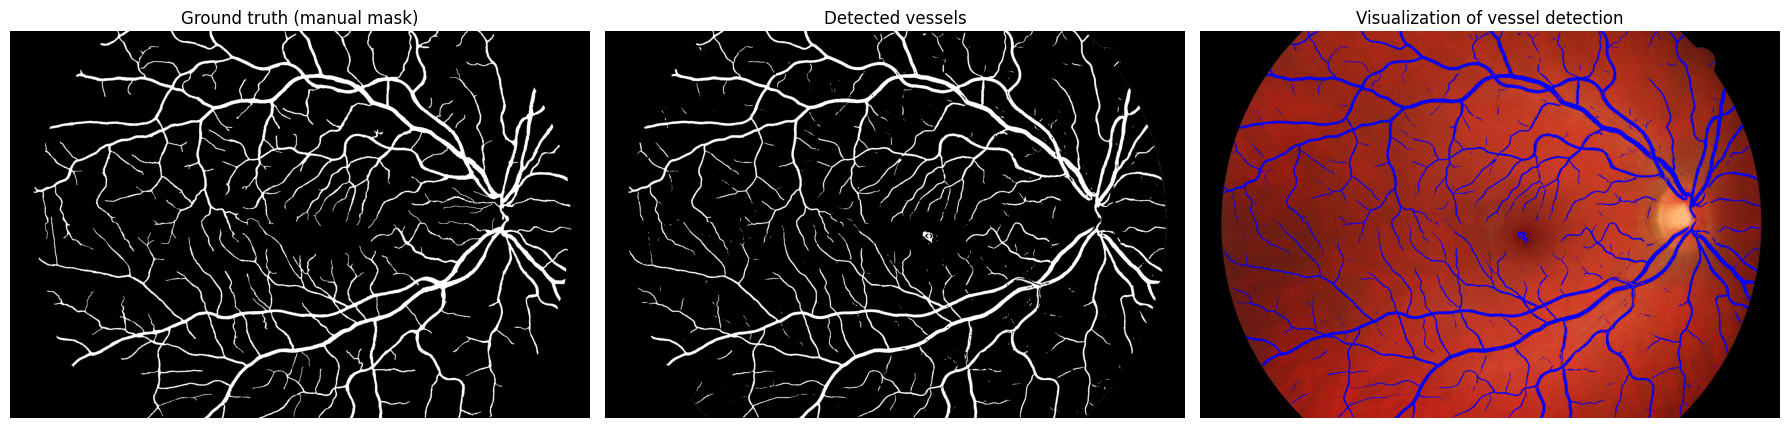

accuracy: 0.9422, sensitivity: 0.9286, specificity: 0.9438, arithmetic mean: 0.9362, geometric mean: 0.9362


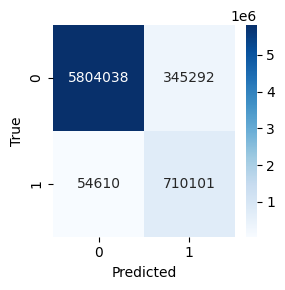


12_h.jpg
58/58 ━━━━━━━━━━━━━━━━━━━━ 9s 162ms/step


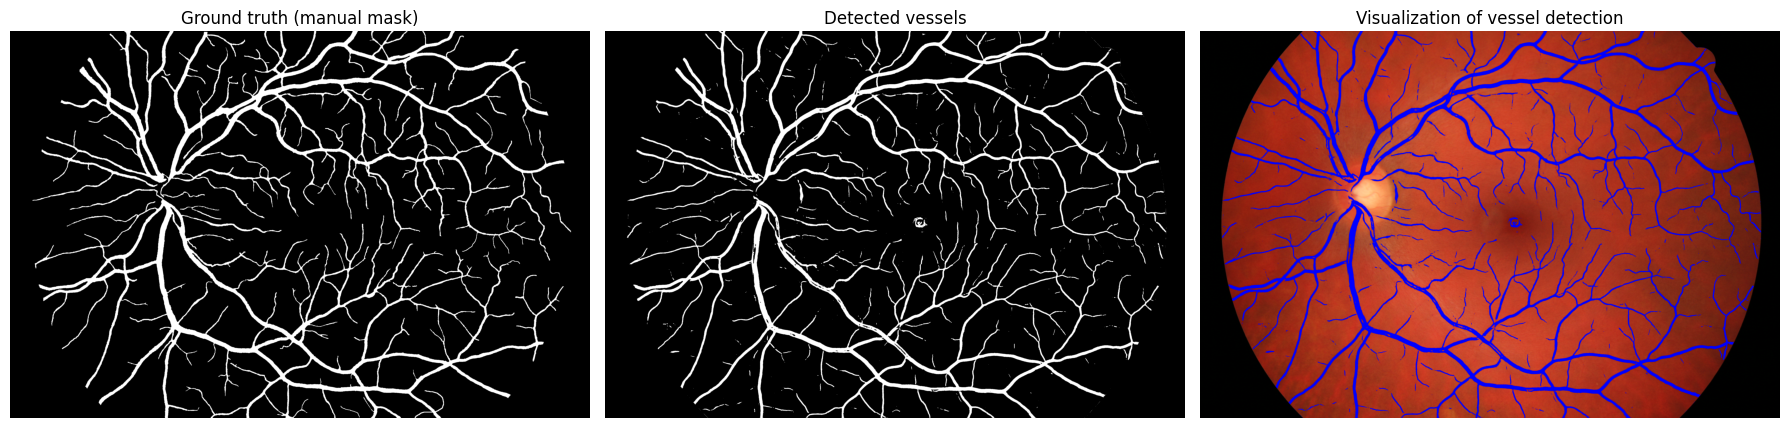

accuracy: 0.9513, sensitivity: 0.9198, specificity: 0.9557, arithmetic mean: 0.9378, geometric mean: 0.9376


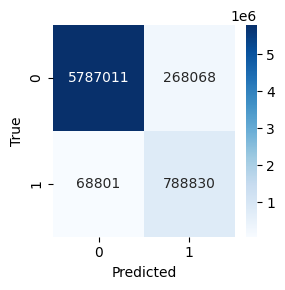

In [34]:
test_files = ["01_h.jpg", "08_h.jpg", "10_h.jpg", "11_h.jpg", "12_h.jpg"]
train_files = ["02_h.jpg", "03_h.jpg", "04_h.jpg", "05_h.jpg", "06_h.jpg"]

model_path = "unet_retina_segmentation.h5"
unet_model = train_or_load_unet(model_path, train_files, epochs=30, batch_size=16)

for file in test_files:
    print(f"\n{file}")
    img, manual, fov = load_image(file)
    predicted = predict_with_unet(unet_model, img, fov)
    binary_prediction = (predicted > 0.5).astype(np.uint8)

    show_results(img, binary_prediction, manual)
    evaluate_detection(manual, predicted, fov)

 